In [4]:
# 1. IMPORT LIBRARIES
from pathlib import Path 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re

# Machine Learning & Preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# Setup Paths
ROOT = Path.cwd().parent
DATA_DIR = ROOT / 'data' 

In [5]:
# 2. READ DATA & OPTIMIZE MEMORY
print(f"Importing files from {DATA_DIR}")
X_raw = pd.read_csv(DATA_DIR / 'x_train.csv')
y_raw = pd.read_csv(DATA_DIR / 'y_train.csv')

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'object':
            df[col] = df[col].astype('category')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df
 
X_raw = optimize_memory(X_raw)
y_raw = optimize_memory(y_raw)
X_eda = X_raw.copy()

print(f"Dataset initial shape: {X_eda.shape}")

Importing files from c:\Users\piere\My Drive\Cours\EDHEC\M2\data_science\hw\data


C:\Users\piere\AppData\Local\Temp\ipykernel_5332\2127616417.py:3: DtypeWarning: Columns (16,17,29,30,31,126,128,129,132,133,135,138,371) have mixed types. Specify dtype option on import or set low_memory=False.
  X_raw = pd.read_csv(DATA_DIR / 'x_train.csv')


Dataset initial shape: (383610, 374)


Shape of the Dataset :  (383610, 377)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Columns: 377 entries, ID to ZONE
dtypes: category(280), float32(39), int32(58)
memory usage: 244.4 MB
None


Text(0.5, 1.0, 'Histogram - lg(CHARGE)')

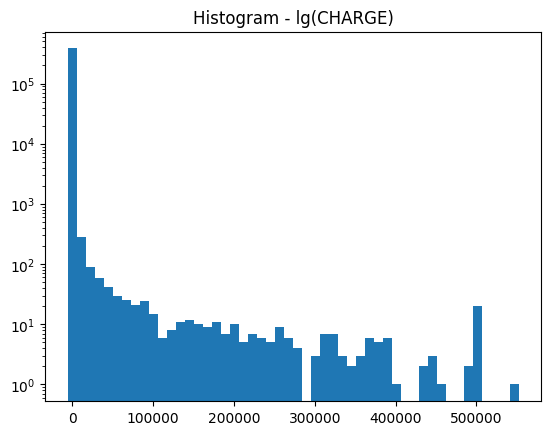

In [19]:
df = pd.merge(y_raw, X_raw)

print("Shape of the Dataset : ",df.shape)
print(df.info())

plt.hist(df['CHARGE'], bins=50)
plt.yscale('log')
plt.title('Histogram - lg(CHARGE)')

Text(0.5, 1.0, 'Histogram - lg(FREQ)')

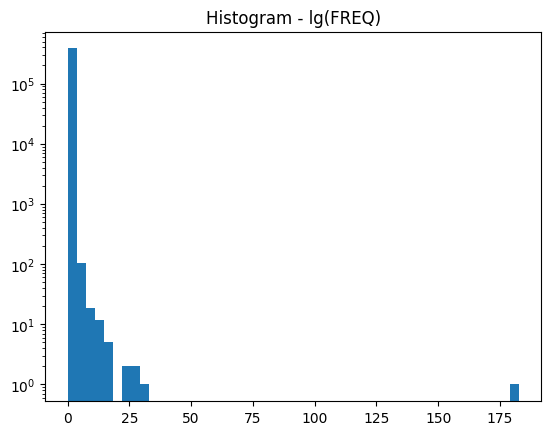

In [18]:
plt.hist(df['FREQ'], bins=50)
plt.yscale('log')
plt.title('Histogram - lg(FREQ)')

Text(0.5, 1.0, 'Histogram - log(CM) where CM !=0')

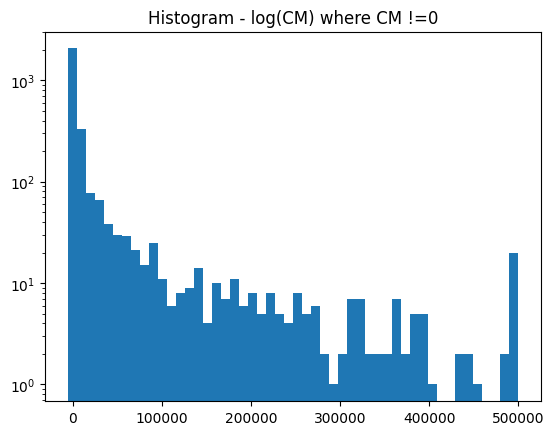

In [17]:
plt.hist(df[df['FREQ'] != 0]['CM'], bins=50)
plt.yscale('log')
plt.title('Histogram - log(CM) where CM !=0')

Text(0.5, 1.0, 'Histogram - lg(CM)')

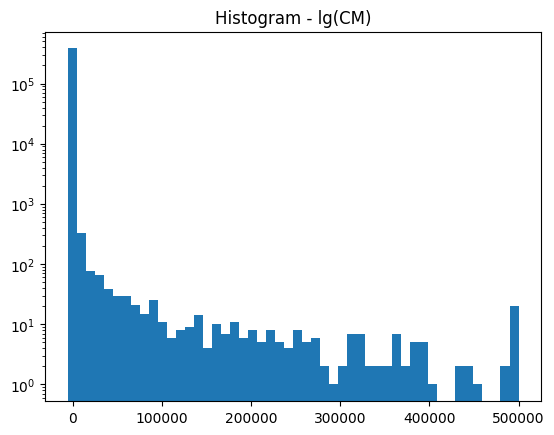

In [16]:
plt.hist(df['CM'], bins=50)
plt.yscale('log')
plt.title('Histogram - lg(CM)')

In [10]:
# 3. DATA CLEANING & FEATURE ENGINEERING
to_drop = ['ID', 'ANNEE_ASSURANCE']

# --- Extraction des tailles ---
def size_extract(val): 
    if pd.isna(val) or str(val) == 'nan' or val == 'MISSING' or val == -1: return np.nan
    match = re.search(r"\[\s*([\d.kM]+)\s*-\s*([\d.kM+]+)\s*\]?", str(val))
    if not match: return np.nan
    low_bound, up_bound = match[1].strip(), match[2].strip()
    unit_list = {'k': 1000, 'M': 1000000}
    
    unit = low_bound[-1]
    low_bound = 0 if low_bound == '0' else float(low_bound[:-1]) * unit_list[unit]

    if '+' in up_bound: return low_bound * 1.1 if low_bound else np.nan
    unit = up_bound[-1]
    up_bound = float(up_bound[:-1]) * unit_list[unit]

    return (low_bound + up_bound) / 2

for col in ['TAILLE1', 'TAILLE2']: 
    if col in X_eda.columns: X_eda[col] = X_eda[col].apply(size_extract)

# --- Extraction des seuils ---
def get_threshold(val):
    if pd.isna(val) or str(val) == 'nan' or val == 'MISSING' or val == -1: return np.nan
    match = re.search(r"\.\s*(<=|>=|>|<)\s*([\d.]+)", str(val))
    return float(match.group(2)) if match else np.nan

cols_to_convert = [col for col in X_eda.select_dtypes(include=['object', 'category']).columns 
                   if X_eda[col].astype(str).str.contains(r'<=|>=|>|<', na=False).any()]
X_eda[cols_to_convert] = X_eda[cols_to_convert].map(get_threshold)

# --- Filtrage des colonnes vides ---
thresh = 0.2 * len(X_eda)
X_clean = X_eda.dropna(thresh=thresh, axis=1)
to_drop.extend([c for c in X_eda.columns if c not in X_clean.columns])

# --- Imputation Basique ---
num_cols = X_eda.select_dtypes(include=['number']).columns
cat_cols = X_eda.select_dtypes(include=['category']).columns

# Zéros, Médianes et -1 selon tes règles
cols_zero = [c for c in num_cols if any(k in c for k in ['KAPITAL', 'SURFACE', 'NBBAT', 'EQUIPEMENT', 'CA', 'RISK', 'TAILLE', 'NBSIN'])]
X_eda[cols_zero] = X_eda[cols_zero].fillna(0)

cols_time = [c for c in num_cols if any(k in c for k in ['ANNEE', 'ANCIENNETE', 'DUREE'])]
for c in cols_time: X_eda[c] = X_eda[c].fillna(X_eda[c].median())

cols_code = [c for c in num_cols if any(k in c for k in ['ZONE', 'TYP', 'ID', 'CARACT', 'DEROG'])]
X_eda[cols_code] = X_eda[cols_code].fillna(-1)
X_eda[num_cols] = X_eda[num_cols].fillna(0)

# Categories avec 'MISSING'
for col in cat_cols:
    if X_eda[col].isnull().any():
        X_eda[col] = X_eda[col].cat.add_categories(['MISSING']).fillna('MISSING')

# --- Variance et Corrélation ---
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_eda[num_cols])
cols_var_keep = num_cols[selector.get_support()]
to_drop.extend([c for c in num_cols if c not in cols_var_keep])

corr_matrix = X_eda[cols_var_keep].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop.extend([column for column in upper.columns if any(upper[column] > 0.95)])

# Application du drop final
X_eda = X_eda.drop(list(set(to_drop)), axis=1, errors='ignore')
print(f"Dataset nettoyé. Shape final: {X_eda.shape}")

Dataset nettoyé. Shape final: (383610, 234)


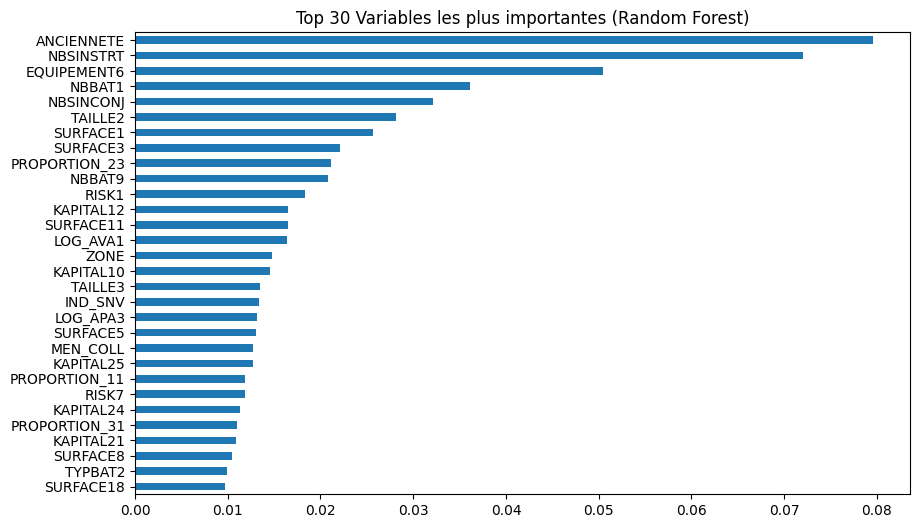

In [11]:
# 4. QUICK FEATURE IMPORTANCE (Random Forest)
X_num_eda = X_eda.select_dtypes(include=['number'])
target_col = 'CHARGE' if 'CHARGE' in y_raw.columns else y_raw.columns[1] 
y_values = y_raw[target_col]

rf = RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42)
rf.fit(X_num_eda, y_values)

feat_imp = pd.Series(rf.feature_importances_, index=X_num_eda.columns).sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh')
plt.title("Top 30 Variables les plus importantes (Random Forest)")
plt.gca().invert_yaxis()
plt.show()

Variance expliquée par 3 axes : 29.92%

Calcul de l'inertie pour la méthode du coude...


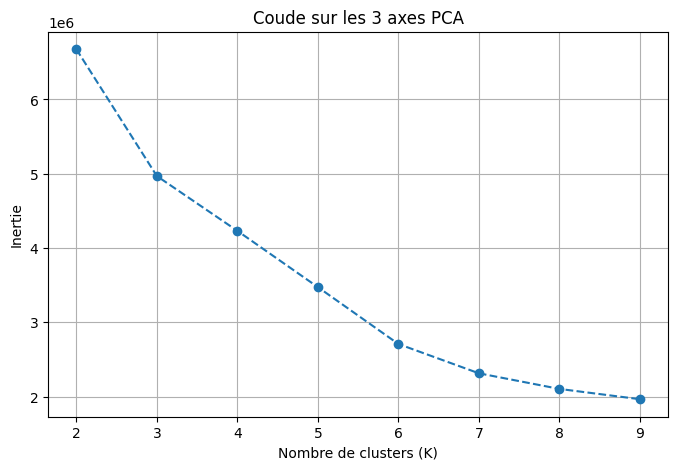

In [ ]:
# 5. PCA POUR REDUCTION DE DIMENSION
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num_eda)

pca = PCA(n_components=3)
components = pca.fit_transform(X_scaled)
print(f"Variance expliquée par 3 axes : {pca.explained_variance_ratio_.sum():.2%}")

# Visualisation du Coude pour K-Means
inertias = []
K_range = range(2, 10)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_temp.fit(components)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.title("Coude sur les 3 axes PCA")
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()

In [ ]:
# 6. K-MEANS ET PROFILING BUSINESS
OPTIMAL_K = 7

kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(components)

df_profiling = X_eda.copy()
df_profiling['Cluster'] = clusters
df_profiling['CIBLE_FREQ'] = y_raw['FREQ'].values
df_profiling['CIBLE_CM'] = y_raw['CM'].values

# Key variables to analyze 
top_features_rf = feat_imp.head(7).index.tolist()

variables_metier = ['CIBLE_FREQ', 'CIBLE_CM'] + top_features_rf 

cols_to_profile = [c for c in variables_metier if c in df_profiling.columns]

for col in cols_to_profile:
    df_profiling[col] = pd.to_numeric(df_profiling[col], errors='coerce')

profil_moyennes = df_profiling.groupby('Cluster')[cols_to_profile].mean().round(2)
profil_moyennes['Poids_Portefeuille (%)'] = (df_profiling['Cluster'].value_counts(normalize=True) * 100).round(1)

print("\n--- PROFIL DES EXPLOITATIONS AGRICOLES ---")
display(profil_moyennes)


--- PROFIL DES EXPLOITATIONS AGRICOLES ---


,CIBLE_FREQ,CIBLE_CM,ANCIENNETE,NBSINSTRT,EQUIPEMENT6,NBBAT1,NBSINCONJ,TAILLE2,SURFACE1,Poids_Portefeuille (%)
Cluster,,,,,,,,,,
0,0.02,241.919998,6.23,0.54,7.60,10.38,0.21,759209.83,2686.31,11.2
1,0.03,522.330017,5.56,0.52,9.10,12.83,0.20,1014698.15,4117.57,14.2
2,0.01,109.660004,3.97,0.21,5.65,6.01,0.08,393012.70,1177.89,19.0
3,0.01,60.880001,5.37,0.14,4.46,4.31,0.05,234467.00,573.63,42.9
4,0.01,356.920013,4.88,0.36,6.43,7.73,0.15,557405.17,1846.78,8.0
5,0.01,26.850000,5.47,0.23,4.66,6.18,0.09,366369.47,1148.30,2.6
6,0.02,243.039993,4.65,0.33,6.70,9.97,0.13,701618.55,2685.86,2.1
